## Metaverse Transaction Data Analysis
 
### Anomaly classifcation (low_risk, medium_risk, high_risk) with meta transaction data

In [5]:
### Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import skopt
import lightgbm as lgb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from skopt.space import Real, Categorical, Integer
from lightgbm import LGBMClassifier

### Other Options
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [10,5]

# Multiple Outputs Per Code Block 
%config InteractiveShell.ast_node_interactivity = 'all'


### Modeling Data Frame

* This script is being refactored. Currently, cannot be run as the necessary tables have not been saved and read in

In [5]:
# Combining Indicator Variables, Sender / Reciever transaction count, and original variables. Omitting variables used to create the classification categories (transaction_type (scam, phishing categories), and risk_score)

meta_model_df = (meta.merge(sender_stats, how = 'left', on = 'sending_address')
                 .merge(receiver_stats, how = 'left', on = 'receiving_address')
                 .merge(indicator_vars, how = 'left', right_index = True, left_index = True)
                 # Reprogram anomaly to be binary to focus on detecting high risk accounts
                 # # # High Risk == 1, Low to moderate Risk == 0 # # #
                 .assign(anomaly_binary = lambda x: x['anomaly'].replace({'low_risk': 0, 'moderate_risk': 0, 'high_risk': 1}),
                         # Make purchases negative transactions to differentiate sales and purchases since transaction_type is being removed
                         amount = lambda x: x['amount'].where(x['transaction_type'] != 'purchase', -x['amount'])
                         )
                 .drop(['timestamp', 'sending_address', 'receiving_address', 'transaction_type', 
                        'location_region', 'ip_prefix', 'risk_score', 'purchase_pattern', 'age_group'], axis = 1)
                 # day of year or num days?
                 ) 

# Training Set and validation set
df_x = meta_model_df.drop(columns = ['anomaly', 'anomaly_binary'])
df_y = meta_model_df['anomaly'] # as category?
  
### Train / Test split. Stratify by underrepresented class
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.25, stratify = df_y, random_state = 152)

# Recombine Training sets to downsample
training_sets = pd.concat([x_train, y_train], axis = 1)
min_class_size = training_sets['anomaly'].value_counts().min() # underepresented class (high risk) count

# Downsample training set to resolve problems with unbalanced data
downsampled_train = (training_sets.groupby('anomaly', group_keys = False)
                     .apply(lambda x: 
                            x.sample(n = min_class_size, random_state = 44, replace = True))
                     # Reshuffle 
                     .sample(frac = 1, random_state = 42))

# Override training sets with downsampled versions
x_train = downsampled_train.drop(columns = 'anomaly')
y_train = downsampled_train['anomaly']


### Halving Grid Search

In [6]:
# Try HalvingGridSearch with Light GBM
classifier = LGBMClassifier()
param_grid = {'objective': ['multiclass'], # ['multiclass']
              'learning_rate': [.05, .1, .2, .25, .4], 
              'max_depth': [4, 5, 6, 7], 
              'num_leaves': [2**4, 2**5, 2**6, 2**7, 2**8], 
              'verbosity': [-1],
              'force_col_wise': [True]
              }

# HalvingGridSearchCV
mini_grid_search = (HalvingGridSearchCV(classifier, param_grid, cv = 2, random_state = 41, n_jobs = -1) 
                    .fit(x_train, y_train)); 

print(f"Best parameters for {classifier}:\n{mini_grid_search.best_params_}")
print(f"Best score: {mini_grid_search.best_score_:.4f}\n") # .9047 binary, .9007 multiclass (lower high-risk accuracy though), without indicator variables

# Thoughts: HalvingGridSearchCV is difficult to use with some Light GBM Params. It requires an explicit grid search, but is resource efficient. It is a good method to select parameters, and it conveniently allows cross validation.


Best parameters for LGBMClassifier():
{'force_col_wise': True, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 32, 'objective': 'multiclass', 'verbosity': -1}
Best score: 0.9007



Thoughts:
* HalvingGridSearchCV is difficult to use with some Light GBM Params.
* Requires an explicit grid search
* Resource efficient - worthwhile if there are computation bottlenecks

## Halving Grid Search Results

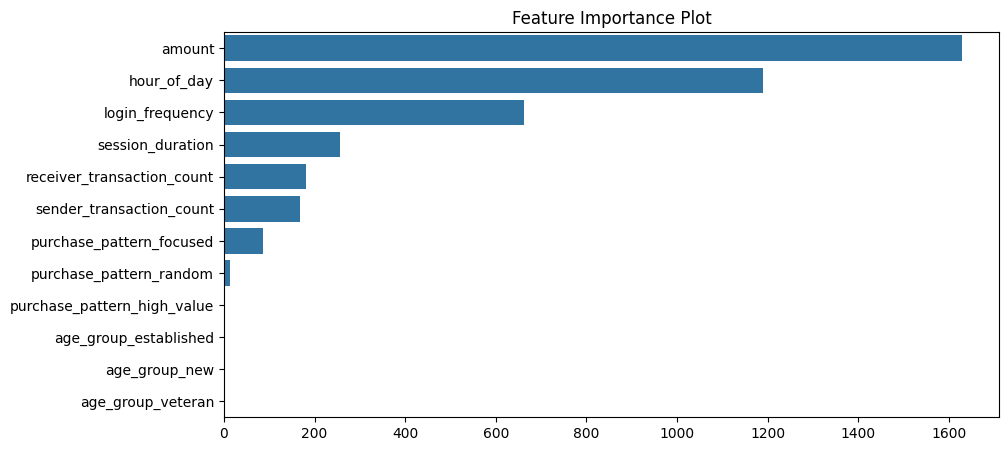

In [7]:
# Predictions on highest performing light gbm model:
y_pred = mini_grid_search.best_estimator_.predict(x_test) 

# Feature Importance Plot
opt_model = LGBMClassifier(**mini_grid_search.best_params_).fit(x_test, y_test)

feature_importance = opt_model.feature_importances_
feature_names = x_test.columns.to_list()

importances_df = pd.DataFrame({"feature_names" : feature_names, 
                              "importances" : feature_importance})

feature_importance_plot = sb.barplot(data = importances_df,
                                      x = feature_importance,
                                      y = feature_names,
                                      order = importances_df.sort_values('importances', ascending = False).feature_names)

plt.title('Feature Importance Plot')
feature_importance_plot; 

               precision    recall  f1-score   support

    high_risk       0.33      0.99      0.50      1624
     low_risk       1.00      0.75      0.86     15873
moderate_risk       0.69      0.96      0.81      2153

     accuracy                           0.79     19650
    macro avg       0.68      0.90      0.72     19650
 weighted avg       0.91      0.79      0.82     19650



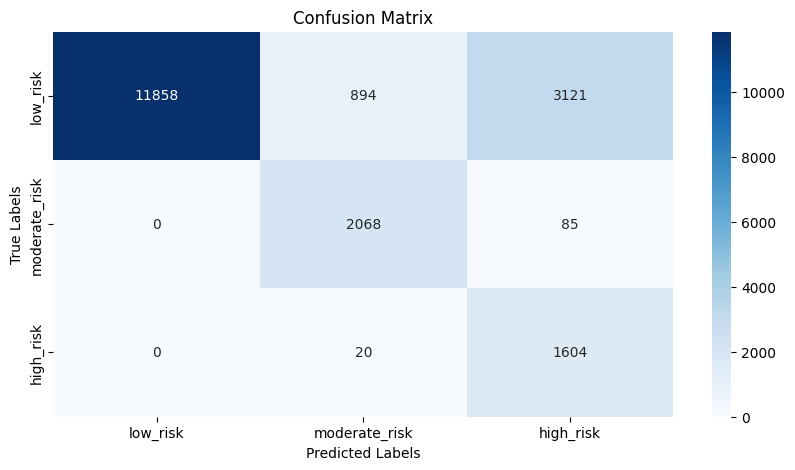

In [8]:
# Report and Confusion Matrix
print(classification_report(y_test, y_pred))
class_labels = ['low_risk', 'moderate_risk', 'high_risk']
cm = confusion_matrix(y_test, y_pred, labels = class_labels) # Are these labels in the right order? 

sb.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show(); 


* The model struggles to classify high risk transactions. 
    * Additional data on the individual transactions could improve this
* Other kaggle members included transaction type, which has high collinearity with risk class
    * This resulted in perfect high risk predictions (All transactions labeled Scam or Phishing had high risk)
    * This is impractical for classifying a high risk classification on data where the risk isn't known
* Critically, this model generalizes to data where the risk score is not already known
    * Not perfect, but a more effective model for industry and detecting fraud

### Bayesian Optimization

In [31]:
### Trying BayesSearchCV 

# Parameter Space
param_space = {
   'learning_rate': Real(0.01, 1, prior = 'uniform'),
   'num_leaves': Integer(10, 50),
   'max_depth': Integer(3, 10),
   'boosting_type': Categorical(['gbdt', 'dart']),
   'feature_fraction': Real(0.1, 1, prior = 'uniform'),
   'subsample': Real(0.1, 1, prior = 'uniform')
}

# Bayesian Optimization with Cross Validation
light_gbm_bayes_cv = skopt.BayesSearchCV(
    estimator = lgb.LGBMClassifier(),
    search_spaces = param_space,
    scoring = 'accuracy', 
    cv = 5,
    n_iter = 50, 
    n_jobs = -1,
    return_train_score = True,
    random_state = 42 
).fit(x_train, y_train); 

# ~ for binary classification 2 minutes to run, greatly dependent on n_iter (number of parameter settings sampled). For multiclass 6.5 minutes

[LightGBM] [Warning] feature_fraction is set=0.894983749642776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894983749642776
[LightGBM] [Warning] feature_fraction is set=0.894983749642776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894983749642776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 14613, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Bayesian Optimization Results

Best Parameters Found: {'boosting_type': 'dart', 'feature_fraction': 0.894983749642776, 'learning_rate': 0.3103760087853332, 'max_depth': 10, 'num_leaves': 45, 'subsample': 0.15608164675966435}
Best Score: 0.9070015874008284
[LightGBM] [Warning] feature_fraction is set=0.894983749642776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894983749642776


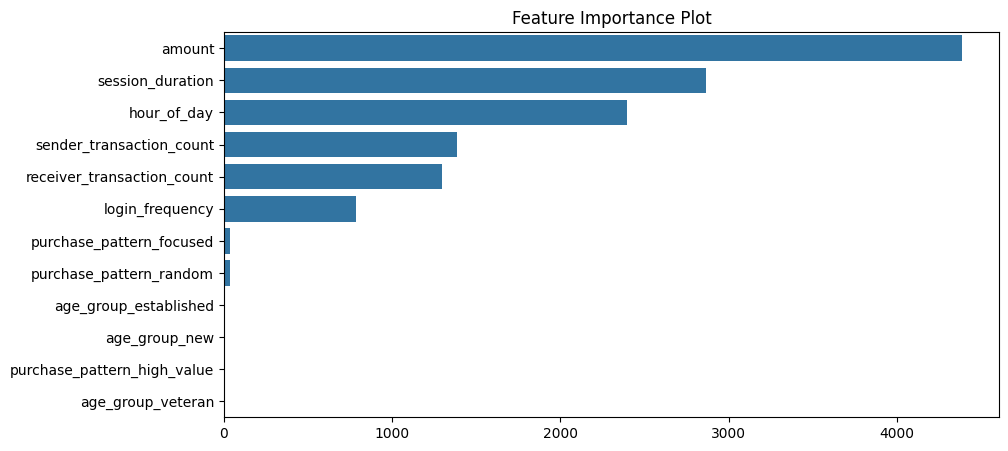

In [34]:
# Best parameters found
print("Best Parameters Found:", dict(light_gbm_bayes_cv.best_params_))
# {'boosting_type': 'dart', 
#  'feature_fraction': 1.0, 
#  'learning_rate': 0.3802263207399061, 
#  'max_depth': 3, 
#  'num_leaves': 10, 
#  'subsample': 0.31848339045102975}

# Best score achieved
print("Best Score:", light_gbm_bayes_cv.best_score_) # .905, .907 for multiclass

# Model Validated using optimal parameters
y_pred = light_gbm_bayes_cv.predict(x_test); # can use predict_proba to give probability ranked scoring of observation

# Feature Importance Plot
opt_model = LGBMClassifier(**light_gbm_bayes_cv.best_params_, verbosity = -1).fit(x_test, y_test); 

feature_importance = opt_model.feature_importances_
feature_names = x_test.columns.to_list()

importances_df = pd.DataFrame({"feature_names" : feature_names, 
                              "importances" : feature_importance})

feature_importance_plot = sns.barplot(data = importances_df,
                                      x = feature_importance,
                                      y = feature_names,
                                      order = importances_df.sort_values('importances', ascending = False).feature_names)

plt.title('Feature Importance Plot')
feature_importance_plot; 

               precision    recall  f1-score   support

    high_risk       0.33      0.94      0.49      1624
     low_risk       1.00      0.75      0.86     15873
moderate_risk       0.69      0.97      0.80      2153

     accuracy                           0.79     19650
    macro avg       0.67      0.89      0.72     19650
 weighted avg       0.91      0.79      0.82     19650



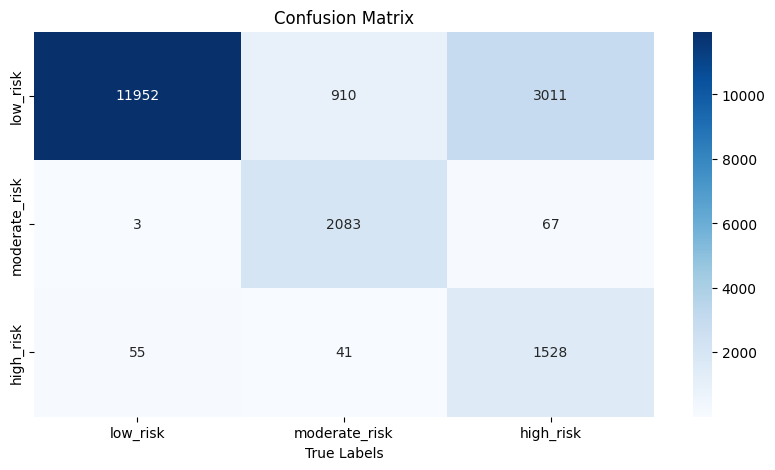

In [35]:
# Report and Confusion Matrix
print(classification_report(y_test, y_pred))
class_labels = ['low_risk', 'moderate_risk', 'high_risk']
cm = confusion_matrix(y_test, y_pred, labels = class_labels);  # Are these labels in the right order? 

sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels); 
plt.xlabel('Predicted Labels'); 
plt.xlabel('True Labels'); 
plt.title('Confusion Matrix'); 
plt.show(); 

# binary_preds = pd.Series(y_pred).reset_index().drop(columns = 'index')
# probs = pd.Series(light_gbm_bayes_cv.predict_proba(x_test)[:,1]).reset_index().drop(columns = 'index'); 
# y_test_result = pd.Series(y_test).reset_index().drop(columns = 'index')

## Test set probability distribution 
# results_df = pd.concat([probs, binary_preds, y_test_result], 
#                        axis = 1, 
#                        keys = ['probs', 'binary_preds', 'y_test_result'])

# results_df.columns = results_df.columns.get_level_values(0)
# results_df.head()

### If using binary classification
# fig, axs = plt.subplots(1, 2, constrained_layout = True)
# sns.histplot(results_df, x = 'probs', 
#              bins = 50, kde = True, ax = axs[0]) # Probability of being a high risk transaction
# # Create his removing the probabilities less than .1
# sns.histplot(results_df[results_df['probs'] > .1], x = 'probs', 
#              bins = 50, kde = True, ax = axs[1], hue = 'y_test_result')


* The results are similar to those found with the model tuned using halving grid search
    * Fewer high risk transactions are accurately classified
* Bayesian Optimization takes significantly longer to select optimal parameters for the model
* The selected parameters lead to a slight performance increase
    * Classifies more low risk transactions correctly
* This method is known to perform better than other grid search techniques, but is less effective for this dataset


## Building a Model Pipeline
* Building a scikit model pipeline
* Will use 4 models 
    * Bayesian Optimization to find optimal parameters
* Input into ensemble models and test performance
    * Comparing Voting and Stack ensemble classifiers

In [ ]:
# Testing Model Pipeline with Bayesian Optimization

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Define the models and their parameter spaces in a dictionary
models_and_param_spaces = {
    "KNN": { 
        "model": KNeighborsClassifier(),
        "param_space": {
            "model__n_neighbors": Integer(1, 30),
            "model__weights": Categorical(['uniform', 'distance']),
            "model__algorithm": Categorical(['ball_tree', 'kd_tree']),
            "model__metric": Categorical(['euclidean', 'manhattan'])
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(), 
        "param_space": {
            "model__solver": Categorical(['saga', 'lbfgs']),
            "model__C": Real(.01, 1, prior = 'uniform')
        }
    },
    "LightGBM": { 
        "model": lgb.LGBMClassifier(),
        "param_space": {
            "model__max_depth": Integer(1, 12),
            'model__learning_rate': Real(0.01, 1, prior = 'uniform'),
            'model__num_leaves': Integer(10, 50),
            'model__max_depth': Integer(3, 10),
            'model__boosting_type': Categorical(['gbdt', 'dart']),
            'model__feature_fraction': Real(0.1, 1, prior = 'uniform'),
            'model__subsample': Real(0.1, 1, prior = 'uniform')
        }
    },
    "RandomForest": { 
        "model": RandomForestClassifier(),
        "param_space": {
            "model__n_estimators": Integer(10, 30),
            "model__max_depth": Integer(1, 12),
            "model__min_samples_split": Integer(2, 20),
            "model__min_samples_leaf": Integer(4, 20),
        }
    }
}

# Perform BayesSearchCV for each model
results = {}
for name, config in models_and_param_spaces.items():
    # Set up pipeline 
    pipe = Pipeline([
        ('model', config['model'])
    ])
    
    # Define the BayesSearchCV object
    opt = skopt.BayesSearchCV(
        estimator = pipe,
        search_spaces = config['param_space'],
        n_iter = 32,  # Number of parameter settings sampled
        cv = 3,       # 3-fold cross-validation
        n_jobs = -1,  # Use all cores
        random_state = 100
    )
    
    # Fit the model
    opt.fit(x_train, y_train)
    
    # Store the results
    results[name] = {
        "best_score": opt.best_score_,
        "best_params": opt.best_params_
    }

# # Display the results
# for model_name, result in results.items():
#     print(f"{model_name} - Best Score: {result['best_score']:.4f}")
#     print(f"Best Parameters: {result['best_params']}\n")


### Ensemble Modeling

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier, VotingClassifier

# Inputting models with their optimized parameters to an ensemble Model
KNN_model = KNeighborsClassifier(algorithm = 'ball_tree', metric = 'manhattan', n_neighbors = 18, weights = 'distance'); 
Log_model = LogisticRegression(C = 0.01019045606548959, solver = 'lbfgs'); 
RF_model = RandomForestClassifier(max_depth = 26, min_samples_leaf = 4, min_samples_split = 2, n_estimators = 30); 
LGBM_model = LGBMClassifier(boosting_type = 'dart', feature_fraction = 0.5276818968015807, verbosity = -1,
                            learning_rate = 0.5950095026466934, max_depth = 10, num_leaves = 24, subsample = 0.9146097001906112); 

# ensemble using vote and stack method
ensemble_vote = VotingClassifier(
    estimators = [('KNN', KNN_model), ('Log', Log_model), ('RF', RF_model), ('LGBM', LGBM_model)],
    voting = 'soft'); 

ensemble_stack = StackingClassifier(
    estimators = [('KNN', KNN_model), ('Log', Log_model), ('RF', RF_model), ('LGBM', LGBM_model)],
    final_estimator = LGBMClassifier()); 

# Create Scores ensemble model using cross-validation
scores_vote = cross_val_score(ensemble_vote, x_train, y_train, cv = 5)
scores_stack = cross_val_score(ensemble_stack, x_train, y_train, cv = 5)


In [ ]:
# ~95% Confidence interval of the Accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_vote.mean(), scores_vote.std() * 2))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_stack.mean(), scores_stack.std() * 2))

# Fit the ensemble models
ensemble_vote.fit(x_train, y_train); 
ensemble_stack.fit(x_train, y_train); 

# Evaluate on the test sets
test_score_vote = ensemble_vote.score(x_test, y_test)
print("Test Score: {:.2f}".format(test_score))

test_score_stack = ensemble_stack.score(x_test, y_test)
print("Test Score: {:.2f}".format(test_score))


Voting and Stacking Ensemble Model Performance
* Both give the same accuracy on the training and validation sets
    * Training: accuracy = .91 (Voting and Stacking)
    * Validation: accuracy = .79 (Voting and Stacking)
    * Lightgbm accuracy is the same, so these models are unnecessary.
* Models are built using same dataset which increases chances of overfitting on the validation set
* The Ensemble inputs, Light GBM and Random Forest, lead to overfitting on the validation set